# Introduction - Titanic Linear Regression

Name: Gabriel Richards / gjrich

Date: 5 Apr 2025

Ever wondered how much people paid for their Titanic tickets? 

This lab uses the Titanic dataset to review regression modeling techniques. Previous work focused on classification (predicting survival), but we'll now predict the fare passengers paid for their journey. We'll review how  passenger attributes like age, family size, and other features correlate with ticket pricing. We'll also build multiple regression models including Linear Regression, Ridge, Elastic Net, and Polynomial Regression, and evaluate their performance using R², RMSE, and MAE to determine which features and models best predict passenger fares.

## Python Package Imports

Before anything else, we'll need to import the packages we'll be using.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler




## Section 1. Import and Inspect the Data

Load the Titanic dataset and confirm it’s structured correctly.


Important: This code requires importing seaborn as sns and pandas. Our variable titanic holds a pandas DataFrame object. Know what imports are required for each bit of code. 

In [2]:
# Load Titanic dataset from seaborn and verify
titanic = sns.load_dataset("titanic")
titanic.head(20)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [4]:
# Check for null/NaN values
null_count = titanic['embark_town'].isna().sum()
print(f"Number of null values in embark_town: {null_count}")

# Check for empty strings
empty_string_count = (titanic['embark_town'] == '').sum()
print(f"Number of empty strings in embark_town: {empty_string_count}")

# Check for whitespace-only strings
whitespace_count = (titanic['embark_town'].str.isspace()).sum()
print(f"Number of whitespace-only strings in embark_town: {whitespace_count}")

# Show rows with missing embark_town
missing_embark = titanic[titanic['embark_town'].isna()]
print("\nRows with missing embark_town:")
print(missing_embark[['survived', 'pclass', 'sex', 'age', 'fare']])

Number of null values in embark_town: 2
Number of empty strings in embark_town: 0
Number of whitespace-only strings in embark_town: 0

Rows with missing embark_town:
     survived  pclass     sex   age  fare
61          1       1  female  38.0  80.0
829         1       1  female  62.0  80.0


## Section 2. Data Exploration and Preparation

Prepare the Titanic data for regression modeling. See the previous work.

- Impute missing values for age using median
- Drop rows with missing fare (or impute if preferred)
- Create numeric variables (e.g., family_size from sibsp + parch + 1)
- Optional - convert categorical features (e.g. sex, embarked) if you think they might help your prediction model. (We do not know relationships until we evaluate things.)

In [5]:
# Calculate the mean and standard deviation of known ages
age_mean = titanic['age'].mean()
age_std = titanic['age'].std()

# Count missing values
age_null_count = titanic['age'].isnull().sum()

# Generate random ages from normal distribution 
np.random.seed(307)  # For reproducibility
age_random_values = np.random.normal(age_mean, age_std, age_null_count)

# Apply age boundary constraints (0 to 85 years)
age_random_values = np.clip(age_random_values, 0, 85)

# Round ages to whole numbers
age_random_values = np.round(age_random_values)

# Create a mask for rows with missing age
age_null_mask = titanic['age'].isnull()

# Fill missing values with the random ages
titanic.loc[age_null_mask, 'age'] = age_random_values

# Round all ages in the dataset for consistency
titanic['age'] = titanic['age'].round()

# Verify no missing age values remain
print(f"Missing age values after imputation: {titanic['age'].isnull().sum()}")

titanic = titanic.dropna(subset=['fare'])

titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

Missing age values after imputation: 0


## Section 3. Feature Selection and Justification
Define multiple combinations of features to use as inputs to predict fare.

Use unique names (X1, y1, X2, y2, etc.) so results are visible and can be compared at the same time. 

Remember the inputs, usually X, are a 2D array. The target is a 1D array. 

In [6]:
# Case 1. age
X1 = titanic[['age']]
y1 = titanic['fare']

In [7]:
# Case 2. family_size
X2 = titanic[['family_size']]
y2 = titanic['fare']

In [8]:
# Case 3. age, family_size
X3 = titanic[['age', 'family_size']]
y3 = titanic['fare']

In [9]:
# Case 4. Embark_town

# Converting embark_town and who to numeric values
# First, make a copy to avoid warnings about modifying the DataFrame
titanic_prep = titanic.copy()

# Convert embark_town to numeric
titanic_prep['embark_town_numeric'] = titanic_prep['embark_town'].map({
    'Southampton': 0, 
    'Cherbourg': 1, 
    'Queenstown': 2
})

# Fill any NaN values that might result from the mapping
titanic_prep['embark_town_numeric'] = titanic_prep['embark_town_numeric'].fillna(0)  # Default to Southampton
# Case 4. embark_town and who (converted to numeric)

X4 = titanic_prep[['embark_town_numeric']]
y4 = titanic_prep['fare']

In [10]:
# Case 5. pclass
X5 = titanic[['pclass']]
y5 = titanic['fare']

### Reflection Questions:

#### Why might these features affect a passenger's fare:
- Embarkation town could affect fare due to varying pricing at each port 
- Additionally, certain ports might have catered to wealthier clientbases

#### List all available features:
- survived, pclass, sex, age, sibsp, parch, fare, embarked, class, who, adult_male, deck, embark_town, alive, alone

#### Which other features could improve predictions and why:
Pclass would likely have the strongest effect as ticket class was the primary fare determinant. Deck could indicate premium accommodation pricing. Family size (sibsp + parch) might reveal group pricing patterns. Age could show different pricing tiers for adults vs. children. Sex might indicate if there were gender-based pricing differences in that era.

#### How many variables are in your Case 4:
One variable: embark_town_numeric

#### Which variable(s) did you choose for Case 4 and why do you feel those could make good inputs:
I chose embark_town because geographic location could significantly impact ticket pricing. Each port had different market conditions, operating costs, and possibly different pricing strategies. Queenstown, Southampton, and Cherbourg likely had different base fare structures. This variable allows the model to detect if location-based pricing was a significant factor independent of passenger class or demographic characteristics.

## Section 4. Train a Regression Model (Linear Regression)


### 4.1 Split the Data


In [11]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=123)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=123)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=123)

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=123)

X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, random_state=123)

### 4.2 Train and Evaluate Linear Regression Models (all 4 cases)


We'll use a more concise approach - create each model and immediately call the fit() method. 

In [12]:
lr_model1 = LinearRegression().fit(X1_train, y1_train)
lr_model2 = LinearRegression().fit(X2_train, y2_train)
lr_model3 = LinearRegression().fit(X3_train, y3_train)
lr_model4 = LinearRegression().fit(X4_train, y4_train)
lr_model5 = LinearRegression().fit(X5_train, y5_train)


# Predictions

y_pred_train1 = lr_model1.predict(X1_train)
y_pred_test1 = lr_model1.predict(X1_test)

y_pred_train2 = lr_model2.predict(X2_train)
y_pred_test2 = lr_model2.predict(X2_test)

y_pred_train3 = lr_model3.predict(X3_train)
y_pred_test3 = lr_model3.predict(X3_test)

y_pred_train4 = lr_model4.predict(X4_train)
y_pred_test4 = lr_model4.predict(X4_test)

y_pred_train5 = lr_model5.predict(X5_train)
y_pred_test5 = lr_model5.predict(X5_test)

### 4.3 Report Performance


In [13]:
# Case 1 Performance
print("Case 1: Training R²:", r2_score(y1_train, y_pred_train1))
print("Case 1: Test R²:", r2_score(y1_test, y_pred_test1))
print("Case 1: Test RMSE:", root_mean_squared_error(y1_test, y_pred_test1))
print("Case 1: Test MAE:", mean_absolute_error(y1_test, y_pred_test1))

# Case 2 Performance
print("Case 2: Training R²:", r2_score(y2_train, y_pred_train2))
print("Case 2: Test R²:", r2_score(y2_test, y_pred_test2))
print("Case 2: Test RMSE:", root_mean_squared_error(y2_test, y_pred_test2))
print("Case 2: Test MAE:", mean_absolute_error(y2_test, y_pred_test2))

# Case 3 Performance
print("Case 3: Training R²:", r2_score(y3_train, y_pred_train3))
print("Case 3: Test R²:", r2_score(y3_test, y_pred_test3))
print("Case 3: Test RMSE:", root_mean_squared_error(y3_test, y_pred_test3))
print("Case 3: Test MAE:", mean_absolute_error(y3_test, y_pred_test3))

# Case 4 Performance
print("Case 4: Training R²:", r2_score(y4_train, y_pred_train4))
print("Case 4: Test R²:", r2_score(y4_test, y_pred_test4))
print("Case 4: Test RMSE:", root_mean_squared_error(y4_test, y_pred_test4))
print("Case 4: Test MAE:", mean_absolute_error(y4_test, y_pred_test4))

# Case 5 Performance
print("Case 5: Training R²:", r2_score(y5_train, y_pred_train5))
print("Case 5: Test R²:", r2_score(y5_test, y_pred_test5))
print("Case 5: Test RMSE:", root_mean_squared_error(y5_test, y_pred_test5))
print("Case 5: Test MAE:", mean_absolute_error(y5_test, y_pred_test5))

Case 1: Training R²: 0.006091065737834356
Case 1: Test R²: 0.005488036891723391
Case 1: Test RMSE: 37.93215355924836
Case 1: Test MAE: 24.981872979129427
Case 2: Training R²: 0.049915792364760736
Case 2: Test R²: 0.022231186110131973
Case 2: Test RMSE: 37.6114940041967
Case 2: Test MAE: 25.02534815941641
Case 3: Training R²: 0.06616670833676175
Case 3: Test R²: 0.04867533008141589
Case 3: Test RMSE: 37.099398958668495
Case 3: Test MAE: 24.126739164110607
Case 4: Training R²: 0.003147509254272318
Case 4: Test R²: 0.008497453278436762
Case 4: Test RMSE: 37.874718285693156
Case 4: Test MAE: 24.752302754209744
Case 5: Training R²: 0.3005588037487471
Case 5: Test R²: 0.3016017234169923
Case 5: Test RMSE: 31.7873316928033
Case 5: Test MAE: 20.653703671484056


### Section 4 Reflection Questions

#### Compare the train vs test results for each.

While I did answer the questions for cases 1-4, it's worth saying that with extremely low R² values, the concepts of overfitting and underfitting become somewhat meaningless. For a model to meaningfully overfit or underfit, there should be an actual pattern in the data that can be captured. When R² values are near zero, they indicate that essentially no relationship exists between the predictors and the target variable, fare.

1. **Did Case 1 overfit or underfit? Explain:**
   Age -  underfit. Both training R² (0.0061) and test R² (0.0055) are extremely low and similar, indicating the model failed to capture meaningful patterns between age and fare.

2. **Did Case 2 overfit or underfit? Explain:**
   family_size - showed slight overfitting. The training R² (0.0499) is more than double the test R² (0.0222), indicating the model learned patterns in training data that didn't generalize well to test data. Still, both values are very low.

3. **Did Case 3 overfit or underfit? Explain:**
   age and family_size - showed slight overfitting as the training R² (0.0662) is higher than the test R² (0.0487). This captured more information than the first two cases, but still explains less than 5% of fare variance.

4. **Did Case 4 overfit or underfit? Explain:**
   embark_town - likely underfit, though it shows with test R² (0.0085) higher than training R² (0.0031). However the R² values suggest random variation in the data split rather than a true pattern.

5. **Did Case 5 overfit or underfit? Explain:**
   pclass - showed balanced fitting. I included it as a bonus sanity test since the correlations were so low on the other cases. The training R² (0.301) and test R² (0.302) are virtually identical, indicating good generalization. This model explains about 30% of fare variance, significantly better than all other cases.


#### Adding Age

1. **Did adding age improve the model:**
   Yes, infinitesmally. Comparing Case 2 (family_size only, R²=0.022) to Case 3 (age and family_size, R²=0.049), adding age did double the test R² and reduced MAE from 25.03 to 24.13...but despite that, the correlation generally remained very low.

2. **Propose a possible explanation:**
   Age might effect ticket price because: 
   (1) different fare structures may have existed for children vs. adults, 
   (2) age may correlate with wealth that influenced cabin class selection 
   (3) families with young children might have required different accommodations. 
   
   However, the low R² values suggest this relationship is still quite weak.


#### Worst

1. **Which case performed the worst:**
   Case 1 - age

2. **How do you know:**
   It has the lowest test R² (0.0055), and the highest RMSE [37.93].

3. **Do you think adding more training data would improve it (and why/why not):**
   No. The problem isn't insufficient data, but that age alone has almost no relationship with fare (R² near zero). More data with the same weak predictor probably wouldn't improve performance.
   

#### Best

1. **Which case performed the best:**
   Case 5  - pclass

2. **How do you know:**
   It has much higher test R² (0.302) than the others. It also has the lowest RMSE (31.79) and MAE (20.65), indicating more accurate predictions.

3. **Do you think adding more training data would improve it (and why/why not):**
   No, I think not. The model already shows consistent generalization, nearly identical between train and test R². However adding different features like deck or combining with other features might likely yield better improvements than more training data.

## Section 5. Compare Alternative Models
In this section, we will take the best-performing case and explore other regression models.

Choose Best Case to Continue
Choose the best case model from the four cases. Use that model to continue to explore additional continuous prediction models. The following assumes that Case 1 was the best predictor  - this may not be the case. Adjust the code to use your best case model instead. 

Choosing Options
When working with regression models, especially those with multiple input features, we may run into overfitting — where a model fits the training data too closely and performs poorly on new data. To prevent this, we can apply regularization.

Regularization adds a penalty to the model’s loss function, discouraging it from using very large weights (coefficients). This makes the model simpler and more likely to generalize well to new data.

In general: 

If the basic linear regression is overfitting, try Ridge.

If you want the model to automatically select the most important features, try Lasso.

If you want a balanced approach, try Elastic Net.

### 5.1 Ridge Regression (L2 penalty)
Ridge Regression is a regularized version of linear regression that adds a penalty to large coefficient values. It uses the L2 penalty, which adds the sum of squared coefficients to the loss function.

This "shrinks" the coefficients, reducing the model’s sensitivity to any one feature while still keeping all features in the model.

Penalty term: L2 = sum of squared weights
Effect: Shrinks weights, helps reduce overfitting, keeps all features

In [14]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X5_train, y5_train)
y_pred_ridge = ridge_model.predict(X5_test)

### 5.2 Elastic Net (L1 + L2 combined)
Lasso Regression uses the L1 penalty, which adds the sum of absolute values of the coefficients to the loss function. Lasso can shrink some coefficients all the way to zero, effectively removing less important features. This makes it useful for feature selection.

Penalty term: L1 = sum of absolute values of weights
Effect: Can shrink some weights to zero (drops features), simplifies the model
Elastic Net combines both L1 (Lasso) and L2 (Ridge) penalties. It balances the feature selection ability of Lasso with the stability of Ridge.

We control the balance with a parameter called l1_ratio:

If l1_ratio = 0, it behaves like Ridge
If l1_ratio = 1, it behaves like Lasso
Values in between mix both types
Penalty term: α × (L1 + L2)
Effect: Shrinks weights and can drop some features — flexible and powerful

In [15]:
elastic_model = ElasticNet(alpha=0.3, l1_ratio=0.5)
elastic_model.fit(X5_train, y5_train)
y_pred_elastic = elastic_model.predict(X5_test)

### 5.3 Polynomial Regression
Linear regression is a simple two dimensional relationship - a simple straight line. But we can test more complex relationships. Polynomial regression adds interaction and nonlinear terms to the model. Be careful here - higher-degree polynomials can easily overfit.

In [16]:
# Set up the poly inputs
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X5_train)
X5_test_poly = poly.transform(X5_test)
 

# Use the poly inputs in the LR model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y5_train)
y_pred_poly = poly_model.predict(X5_test_poly)

### 5.4 Visualize Polynomial Cubic Fit (for 1 input feature)
Choose a case with just one input feature and plot it. For example:

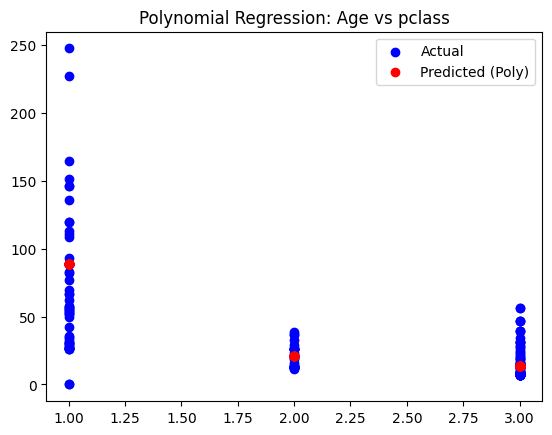

In [17]:
plt.scatter(X5_test, y5_test, color='blue', label='Actual')
plt.scatter(X5_test, y_pred_poly, color='red', label='Predicted (Poly)')
plt.legend()
plt.title("Polynomial Regression: Age vs pclass")
plt.show()

In [18]:
def report(name, y_true, y_pred):
    print(f"{name} R²: {r2_score(y_true, y_pred):.3f}")
    print(f"{name} RMSE: {root_mean_squared_error(y_true, y_pred):.2f}")
    print(f"{name} MAE: {mean_absolute_error(y_true, y_pred):.2f}\n")

report("Linear", y5_test, y_pred_test5)
report("Ridge", y5_test, y_pred_ridge)
report("ElasticNet", y5_test, y_pred_elastic)
report("Polynomial", y5_test, y_pred_poly)

Linear R²: 0.302
Linear RMSE: 31.79
Linear MAE: 20.65

Ridge R²: 0.302
Ridge RMSE: 31.77
Ridge MAE: 20.64

ElasticNet R²: 0.339
ElasticNet RMSE: 30.92
ElasticNet MAE: 19.93

Polynomial R²: 0.336
Polynomial RMSE: 30.99
Polynomial MAE: 19.25



### 5.4 Reflections

1. What patterns does the cubic model seem to capture:
   - Model clusters them by each class (1, 2, and 3), with first class (1) having the highest fares, second class (2) having medium fares, and third class (3) having the lowest fares. The model creates a curve that attempts to fit these discrete class-based fare differences
2. Where does it perform well or poorly:
   - The model performs well at establishing the general relationship between class and fare (higher class = higher fare). It struggles with the variance in fares within each class, particularly in first class where the fare values range dramatically from $30 to nearly $250.
3. Did the polynomial fit outperform linear regression:
   - The polynomial fit (R² = 0.336, RMSE = 30.99, MAE = 19.25) slightly outperformed the linear regression model (R² = 0.302, RMSE = 31.79, MAE = 20.65). The ElasticNet model actually performed slightly better than both with R² = 0.339. The improvement is modest but consistent across all evaluation metrics.
4. Where (on the graph or among which kinds of data points) does it fit best:  Like other models, it would struggle most with first class passengers where there's tremendous fare variability. The ElasticNet's regularization helps it avoid overfitting to outliers in the first class, allowing it to create a more balanced fit across all classes while still capturing the essential relationship between passenger class and fare.

### 5.5 Visualize Higher Order Polynomial (for the same 1 input case)

Use the same single input case as you visualized above, but use a higher degree polynomial (e.g. 4, 5, 6, 7, or 8). Plot the result. 

In a Markdown cell, tell us which option seems to work better - your initial cubic (3) or your higher order and why. 

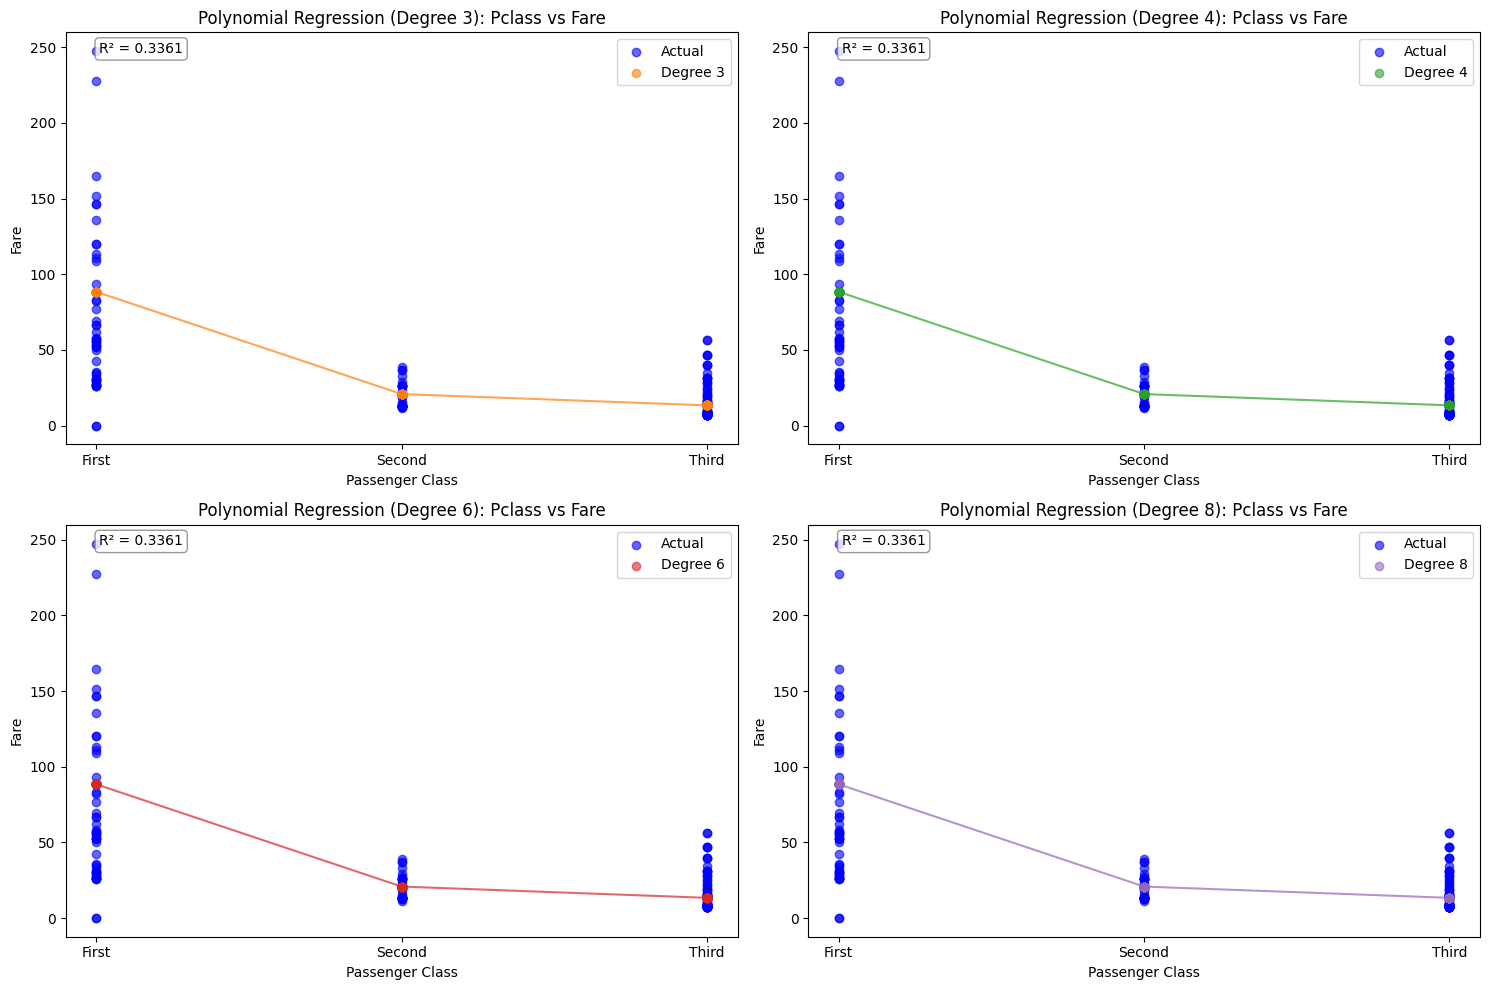

Performance Metrics for Different Polynomial Degrees (Pclass):

Polynomial Degree 3:
R²: 0.3361
RMSE: 30.99
MAE: 19.25
----------------------------------------
Polynomial Degree 4:
R²: 0.3361
RMSE: 30.99
MAE: 19.25
----------------------------------------
Polynomial Degree 6:
R²: 0.3361
RMSE: 30.99
MAE: 19.25
----------------------------------------
Polynomial Degree 8:
R²: 0.3361
RMSE: 30.99
MAE: 19.25
----------------------------------------


In [19]:
# Testing multiple polynomial degrees using pclass as the input feature
degrees = [3, 4, 6, 8]
poly_models_pclass = {}
y_preds_pclass = {}
r2_scores_pclass = {}

# Train models for each degree
for degree in degrees:
    # Create polynomial features
    poly_transformer = PolynomialFeatures(degree=degree)
    X_train_poly_deg = poly_transformer.fit_transform(X5_train)  # Using X5 (pclass) instead of X1 (age)
    X_test_poly_deg = poly_transformer.transform(X5_test)
    
    # Train model
    model = LinearRegression()
    model.fit(X_train_poly_deg, y5_train)
    
    # Generate predictions
    y_pred = model.predict(X_test_poly_deg)
    
    # Store results
    poly_models_pclass[degree] = model
    y_preds_pclass[degree] = y_pred
    r2_scores_pclass[degree] = r2_score(y5_test, y_pred)

# Create plots for each degree
plt.figure(figsize=(15, 10))

for i, degree in enumerate(degrees, 1):
    plt.subplot(2, 2, i)
    plt.scatter(X5_test, y5_test, color='blue', alpha=0.6, label='Actual')
    plt.scatter(X5_test, y_preds_pclass[degree], color=f'C{i}', alpha=0.6, label=f'Degree {degree}')
    
    # Create sorted data for a cleaner line plot
    sorted_indices = X5_test.iloc[:, 0].argsort()
    sorted_X = X5_test.iloc[sorted_indices]
    sorted_y_pred = y_preds_pclass[degree][sorted_indices]
    
    # Draw a line connecting predictions
    plt.plot(sorted_X, sorted_y_pred, color=f'C{i}', linestyle='-', alpha=0.7)
    
    plt.title(f"Polynomial Regression (Degree {degree}): Pclass vs Fare")
    plt.xlabel("Passenger Class")
    plt.ylabel("Fare")
    plt.legend()
    plt.xticks([1, 2, 3], ['First', 'Second', 'Third'])
    
    # Add R² value to plot
    plt.annotate(f"R² = {r2_scores_pclass[degree]:.4f}", 
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

# Report performance metrics for each model
print("Performance Metrics for Different Polynomial Degrees (Pclass):\n")
for degree in degrees:
    print(f"Polynomial Degree {degree}:")
    print(f"R²: {r2_scores_pclass[degree]:.4f}")
    print(f"RMSE: {root_mean_squared_error(y5_test, y_preds_pclass[degree]):.2f}")
    print(f"MAE: {mean_absolute_error(y5_test, y_preds_pclass[degree]):.2f}")
    print("-" * 40)

### P-class Polynomial Regression Review

R^2 values are good compared to other cases, but clearly changing the degree makes no difference and the visualizations are unclear. Let's try combining P-class with family size.

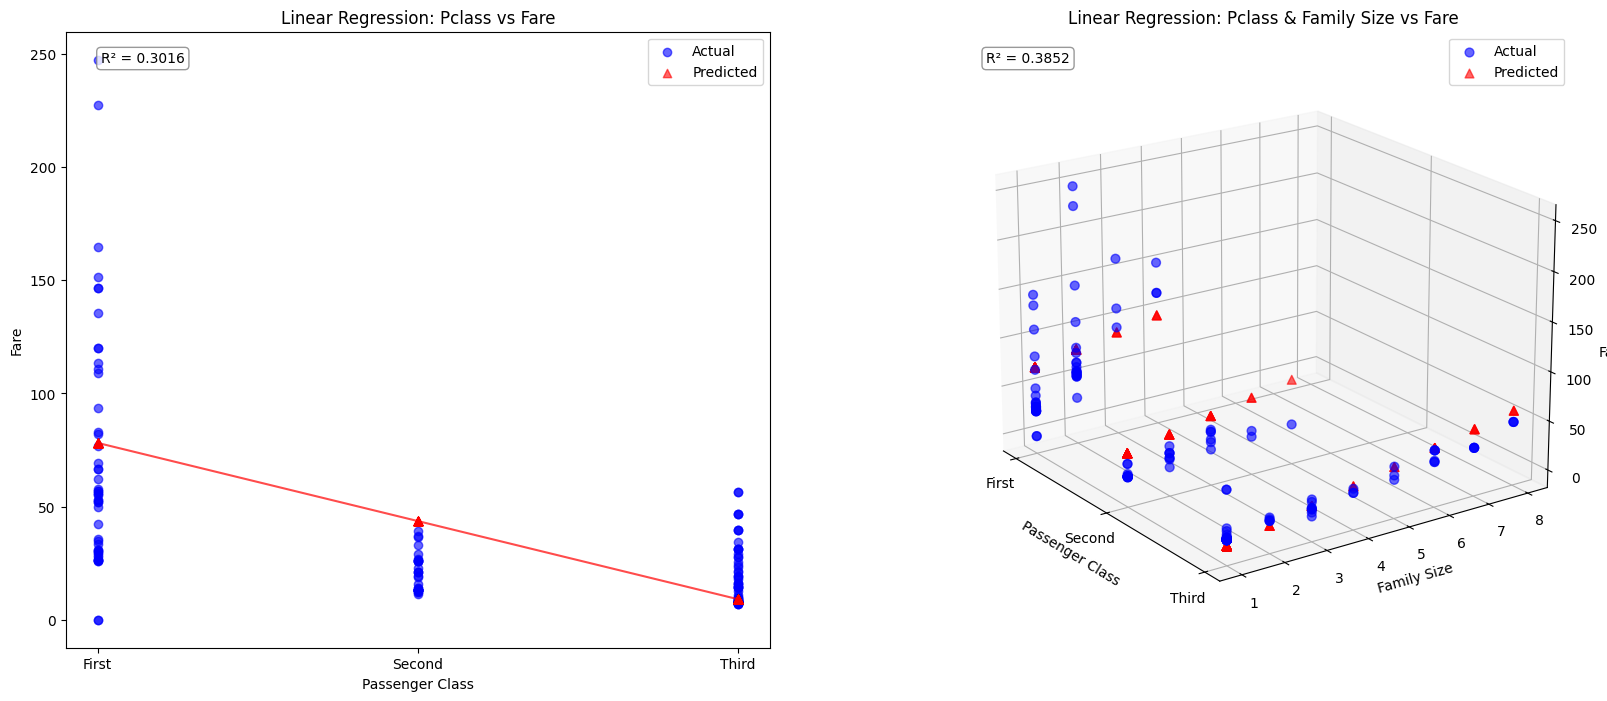

Pclass Only Model:
R²: 0.3016
RMSE: 31.79
MAE: 20.65
----------------------------------------
Pclass + Family Size Model:
R²: 0.3852
RMSE: 29.83
MAE: 20.15


In [20]:
# Create feature sets
X_pclass = titanic[['pclass']]
X_combined = titanic[['pclass', 'family_size']]

# Split the data
X_pclass_train, X_pclass_test, y_pclass_train, y_pclass_test = train_test_split(
    X_pclass, titanic['fare'], test_size=0.2, random_state=123)
X_combined_train, X_combined_test, y_combined_train, y_combined_test = train_test_split(
    X_combined, titanic['fare'], test_size=0.2, random_state=123)

# Train linear regression models
lr_pclass = LinearRegression()
lr_pclass.fit(X_pclass_train, y_pclass_train)
y_pred_pclass = lr_pclass.predict(X_pclass_test)

lr_combined = LinearRegression()
lr_combined.fit(X_combined_train, y_combined_train)
y_pred_combined = lr_combined.predict(X_combined_test)

# Create a figure with two subplots side by side
fig = plt.figure(figsize=(20, 8))

# Plot 1: Pclass only (2D plot)
ax1 = fig.add_subplot(121)
ax1.scatter(X_pclass_test, y_pclass_test, color='blue', alpha=0.6, marker='o', label='Actual')
ax1.scatter(X_pclass_test, y_pred_pclass, color='red', alpha=0.6, marker='^', label='Predicted')

# Create sorted data for a cleaner line plot
sorted_indices = X_pclass_test.iloc[:, 0].argsort()
sorted_X = X_pclass_test.iloc[sorted_indices]
sorted_y_pred = y_pred_pclass[sorted_indices]

# Draw a line connecting predictions
ax1.plot(sorted_X, sorted_y_pred, color='red', linestyle='-', alpha=0.7)

ax1.set_xlabel('Passenger Class')
ax1.set_ylabel('Fare')
ax1.set_title('Linear Regression: Pclass vs Fare')
ax1.set_xticks([1, 2, 3])
ax1.set_xticklabels(['First', 'Second', 'Third'])
ax1.legend(loc='upper right')

# Add R² value to plot
ax1.text(0.05, 0.95, f"R² = {r2_score(y_pclass_test, y_pred_pclass):.4f}", 
         transform=ax1.transAxes,
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Plot 2: Pclass and Family Size (3D plot)
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_combined_test['pclass'], X_combined_test['family_size'], y_combined_test, 
           color='blue', alpha=0.6, marker='o', s=40, label='Actual')
ax2.scatter(X_combined_test['pclass'], X_combined_test['family_size'], y_pred_combined, 
           color='red', alpha=0.6, marker='^', s=40, label='Predicted')

ax2.set_xlabel('Passenger Class')
ax2.set_ylabel('Family Size')
ax2.set_zlabel('Fare')
ax2.set_title('Linear Regression: Pclass & Family Size vs Fare')
ax2.set_xticks([1, 2, 3])
ax2.set_xticklabels(['First', 'Second', 'Third'])
ax2.view_init(elev=20, azim=-35)

# Add R² value to plot
ax2.text2D(0.05, 0.95, f"R² = {r2_score(y_combined_test, y_pred_combined):.4f}", 
         transform=ax2.transAxes,
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
ax2.legend(loc='upper right')

plt.show()

# Print performance metrics for comparison
print("Pclass Only Model:")
print(f"R²: {r2_score(y_pclass_test, y_pred_pclass):.4f}")
print(f"RMSE: {root_mean_squared_error(y_pclass_test, y_pred_pclass):.2f}")
print(f"MAE: {mean_absolute_error(y_pclass_test, y_pred_pclass):.2f}")
print("-" * 40)

print("Pclass + Family Size Model:")
print(f"R²: {r2_score(y_combined_test, y_pred_combined):.4f}")
print(f"RMSE: {root_mean_squared_error(y_combined_test, y_pred_combined):.2f}")
print(f"MAE: {mean_absolute_error(y_combined_test, y_pred_combined):.2f}")

Interesting. Adding this complexity notably increased the R^2 value, from 0.3361 on the Polynomial regression of p-cl to 0.3852. What if we test 

C:\Users\bob\AppData\Local\Temp\ipykernel_15452\1169610010.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


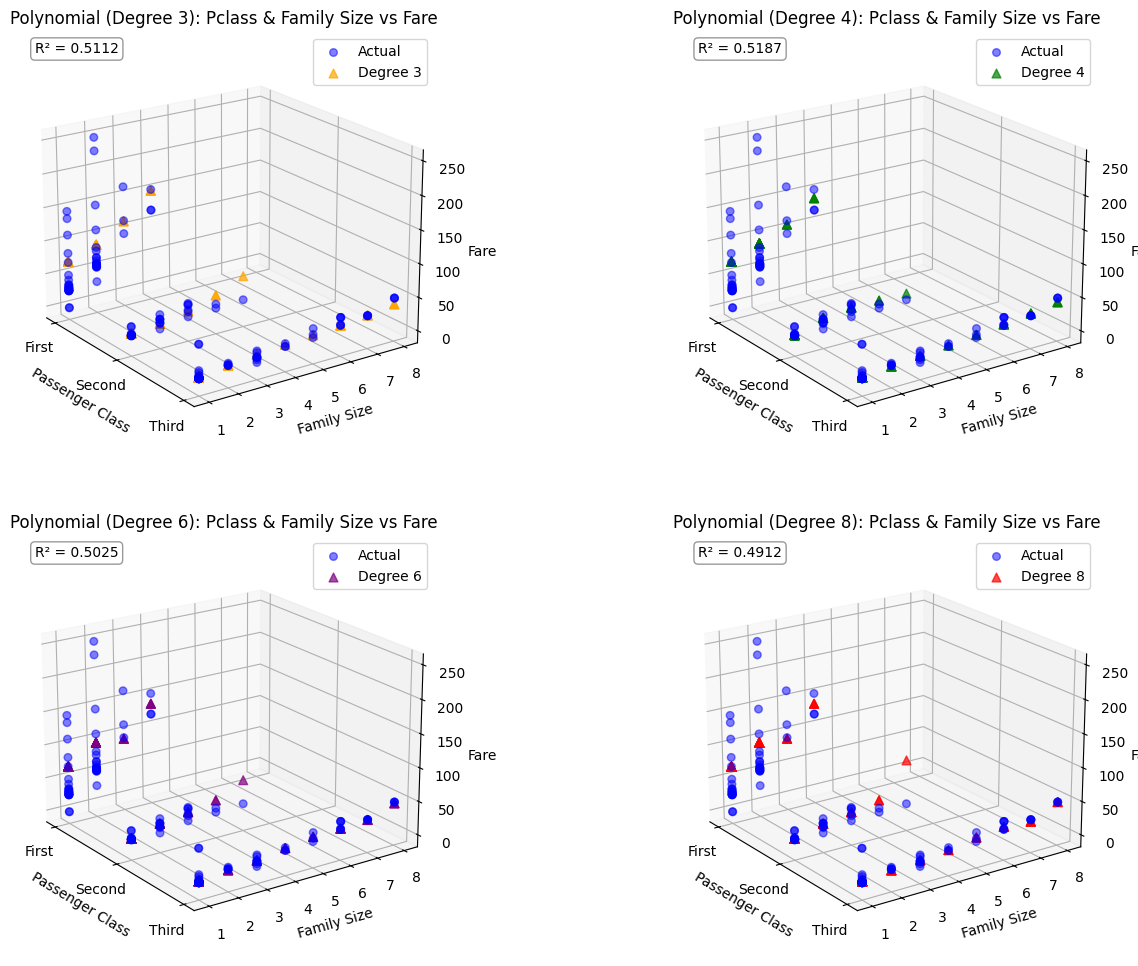

Performance Metrics for Different Polynomial Degrees (Combined Features):

Polynomial Degree 3 (orange):
R²: 0.5112
RMSE: 26.59
MAE: 13.92
----------------------------------------
Polynomial Degree 4 (green):
R²: 0.5187
RMSE: 26.39
MAE: 13.72
----------------------------------------
Polynomial Degree 6 (purple):
R²: 0.5025
RMSE: 26.83
MAE: 14.20
----------------------------------------
Polynomial Degree 8 (red):
R²: 0.4912
RMSE: 27.13
MAE: 14.39
----------------------------------------


In [21]:
# Testing multiple polynomial degrees with combined features
degrees = [3, 4, 6, 8]
poly_models_combined = {}
y_preds_combined = {}
r2_scores_combined = {}

# Define distinct colors for better contrast
colors = ['orange', 'green', 'purple', 'red']

# Train models for each degree
for degree in degrees:
    # Create polynomial features
    poly_transformer = PolynomialFeatures(degree=degree)
    X_train_poly_deg = poly_transformer.fit_transform(X_combined_train)
    X_test_poly_deg = poly_transformer.transform(X_combined_test)
    
    # Train model
    model = LinearRegression()
    model.fit(X_train_poly_deg, y_combined_train)
    
    # Generate predictions
    y_pred = model.predict(X_test_poly_deg)
    
    # Store results
    poly_models_combined[degree] = model
    y_preds_combined[degree] = y_pred
    r2_scores_combined[degree] = r2_score(y_combined_test, y_pred)

# Create plots for each degree using 3D visualization
plt.figure(figsize=(16, 12))

for i, degree in enumerate(degrees):
    # Create 3D subplot
    ax = plt.subplot(2, 2, i+1, projection='3d')
    
    # Plot actual data points
    ax.scatter(X_combined_test['pclass'], X_combined_test['family_size'], y_combined_test, 
               color='blue', alpha=0.5, marker='o', s=30, label='Actual')
    
    # Plot predicted data points
    ax.scatter(X_combined_test['pclass'], X_combined_test['family_size'], y_preds_combined[degree], 
               color=colors[i], alpha=0.7, marker='^', s=40, label=f'Degree {degree}')
    
    # Set labels and title
    ax.set_xlabel('Passenger Class')
    ax.set_ylabel('Family Size')
    ax.set_zlabel('Fare')
    ax.set_title(f"Polynomial (Degree {degree}): Pclass & Family Size vs Fare")
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['First', 'Second', 'Third'])
    
    # Set a lower viewing angle
    ax.view_init(elev=20, azim=-35)  # Lower elevation, adjust azimuth
    
    # Add R² value to plot
    ax.text2D(0.05, 0.95, f"R² = {r2_scores_combined[degree]:.4f}", 
             transform=ax.transAxes,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    # Add legend
    ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.2)  # Adjust spacing
plt.show()

# Report performance metrics for each model
print("Performance Metrics for Different Polynomial Degrees (Combined Features):\n")
for i, degree in enumerate(degrees):
    print(f"Polynomial Degree {degree} ({colors[i]}):")
    print(f"R²: {r2_scores_combined[degree]:.4f}")
    print(f"RMSE: {root_mean_squared_error(y_combined_test, y_preds_combined[degree]):.2f}")
    print(f"MAE: {mean_absolute_error(y_combined_test, y_preds_combined[degree]):.2f}")
    print("-" * 40)

The decreasing R² value as the polynomial degree increases (from degree 4 to degrees 6 and 8) is indeed a classic sign of overfitting. Here's what's happening:

With degree 4 (R² = 0.5187), the model has found a good balance between complexity and generalization. It captures the underlying patterns in the data without fitting to noise.
As we increase to degree 6 (R² = 0.5025), the model becomes more complex but actually performs worse on test data. This suggests it's starting to fit to random fluctuations in the training data.
By degree 8 (R² = 0.4912), the overfitting is even more pronounced, with further decreased performance.

This pattern is a textbook example of the bias-variance tradeoff in machine learning:

Too simple (low degree): high bias, underfitting
Good balance (degree 4): captures real patterns 
Too complex (higher degrees): high variance, overfitting

This is why it's generally good practice to try multiple model complexities and select the one that performs best on validation/test data rather than just assuming that more complexity will always yield better results.

In [ ]:
# Load the Titanic dataset
titanic = sns.load_dataset("titanic")

# Basic data preparation
titanic['age'].fillna(titanic['age'].median(), inplace=True)
titanic = titanic.dropna(subset=['fare'])
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

# Extract features and target
X = titanic[['pclass', 'family_size']]
y = titanic['fare']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

# Method 1: Feature Transformation with Elastic Net
def optimize_feature_transformation():
    """
    Optimize polynomial degree transformation with Elastic Net
    """
    print("\n=== METHOD 1: FEATURE TRANSFORMATION WITH ELASTIC NET ===")
    
    degrees = list(range(1, 6))  # Try polynomial degrees 1-5
    alphas = [0.001, 0.01, 0.1, 1.0, 10.0]
    l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
    
    results = []
    
    for degree in degrees:
        # Set up a pipeline with polynomial features and elastic net
        pipeline = Pipeline([
            ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
            ('scaler', StandardScaler()),
            ('elasticnet', ElasticNet(max_iter=10000, tol=1e-4))
        ])
        
        # Set up parameter grid
        param_grid = {
            'elasticnet__alpha': alphas,
            'elasticnet__l1_ratio': l1_ratios
        }
        
        # Use 5-fold cross-validation
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # Grid search with cross-validation
        grid = GridSearchCV(
            pipeline, param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=0
        )
        
        grid.fit(X_train, y_train)
        
        # Get results
        y_pred = grid.predict(X_test)
        test_r2 = r2_score(y_test, y_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        results.append({
            'degree': degree,
            'best_alpha': grid.best_params_['elasticnet__alpha'],
            'best_l1_ratio': grid.best_params_['elasticnet__l1_ratio'],
            'train_r2': grid.best_score_,
            'test_r2': test_r2,
            'test_rmse': test_rmse
        })
        
        print(f"Degree {degree}: Best params = {grid.best_params_}, Test R² = {test_r2:.4f}")
        
    # Find best result
    best_result = max(results, key=lambda x: x['test_r2'])
    print(f"\nBest feature transformation: Polynomial degree {best_result['degree']}")
    print(f"Best alpha: {best_result['best_alpha']}")
    print(f"Best l1_ratio: {best_result['best_l1_ratio']}")
    print(f"Test R²: {best_result['test_r2']:.4f}")
    print(f"Test RMSE: {best_result['test_rmse']:.4f}")
    
    return best_result


# Method 2: Log Transform Target with Elastic Net
def optimize_target_transformation():
    """
    Try log transformation of the target variable (fare)
    """
    print("\n=== METHOD 2: TARGET TRANSFORMATION WITH ELASTIC NET ===")
    
    # Create log-transformed target pipeline
    log_pipe = Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('elasticnet', ElasticNet(max_iter=10000, tol=1e-4))
    ])
    
    # Target transformer using natural log (handles positive values only)
    # The fare values should all be positive, so this should work
    target_transformer = TransformedTargetRegressor(
        regressor=log_pipe,
        func=np.log1p,  # log(1+x) to handle zero values
        inverse_func=lambda x: np.expm1(x)  # exp(x)-1
    )
    
    # Set up parameter grid
    param_grid = {
        'regressor__elasticnet__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
        'regressor__elasticnet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }
    
    # Use 5-fold cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Grid search with cross-validation
    grid = GridSearchCV(
        target_transformer, param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=0
    )
    
    grid.fit(X_train, y_train)
    
    # Get results
    y_pred = grid.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"Best params = {grid.best_params_}")
    print(f"Train R² = {grid.best_score_:.4f}")
    print(f"Test R² = {test_r2:.4f}")
    print(f"Test RMSE = {test_rmse:.4f}")
    
    return {
        'best_alpha': grid.best_params_['regressor__elasticnet__alpha'],
        'best_l1_ratio': grid.best_params_['regressor__elasticnet__l1_ratio'],
        'train_r2': grid.best_score_,
        'test_r2': test_r2,
        'test_rmse': test_rmse
    }


# Method 3: Elastic Net with Custom Features
def optimize_custom_features():
    """
    Create custom features based on domain knowledge
    """
    print("\n=== METHOD 3: ELASTIC NET WITH CUSTOM FEATURES ===")
    
    # Create a temporary dataframe for feature engineering
    df = titanic.copy()
    
    # Create custom features
    df['fare_per_person'] = df['fare'] / df['family_size']
    df['pclass_squared'] = df['pclass'] ** 2
    df['family_size_squared'] = df['family_size'] ** 2
    df['pclass_family_interaction'] = df['pclass'] * df['family_size']
    
    # Select features
    custom_X = df[['pclass', 'family_size', 'pclass_squared', 
                   'family_size_squared', 'pclass_family_interaction']]
    
    # Drop rows with infinite or missing values from feature engineering
    mask = np.isfinite(custom_X).all(axis=1)
    custom_X = custom_X[mask]
    custom_y = df['fare'][mask]
    
    # Split the data again
    X_train_custom, X_test_custom, y_train_custom, y_test_custom = train_test_split(
        custom_X, custom_y, test_size=0.2, random_state=123
    )
    
    # Create a pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('elasticnet', ElasticNet(max_iter=10000, tol=1e-4))
    ])
    
    # Parameter grid
    param_grid = {
        'elasticnet__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
        'elasticnet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }
    
    # Use 5-fold cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Grid search
    grid = GridSearchCV(
        pipeline, param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=0
    )
    
    grid.fit(X_train_custom, y_train_custom)
    
    # Get results
    y_pred = grid.predict(X_test_custom)
    test_r2 = r2_score(y_test_custom, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test_custom, y_pred))
    
    print(f"Best params = {grid.best_params_}")
    print(f"Train R² = {grid.best_score_:.4f}")
    print(f"Test R² = {test_r2:.4f}")
    print(f"Test RMSE = {test_rmse:.4f}")
    
    # Feature importance analysis
    best_model = grid.best_estimator_.named_steps['elasticnet']
    feature_names = custom_X.columns
    
    # Print coefficients
    coef = best_model.coef_
    importance = np.abs(coef)
    
    # Sort by importance
    indices = np.argsort(importance)[::-1]
    
    print("\nFeature Importance:")
    for i in indices:
        if coef[i] != 0:  # Only show non-zero coefficients
            print(f"{feature_names[i]}: {coef[i]:.4f}")
    
    return {
        'best_alpha': grid.best_params_['elasticnet__alpha'],
        'best_l1_ratio': grid.best_params_['elasticnet__l1_ratio'],
        'train_r2': grid.best_score_,
        'test_r2': test_r2,
        'test_rmse': test_rmse
    }


# Method 4: Robust Elastic Net with Hyperparameter Fine-Tuning
def optimize_hyperparam_finetuning():
    """
    Fine-tune hyperparameters with exhaustive search
    """
    print("\n=== METHOD 4: ROBUST ELASTIC NET WITH HYPERPARAMETER FINE-TUNING ===")
    
    # Best polynomial degree from method 1
    best_degree = 2  # This will be updated based on method 1 results
    
    # Create a more focused pipeline
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
        ('scaler', StandardScaler()),
        ('elasticnet', ElasticNet(max_iter=10000, tol=1e-4))
    ])
    
    # More focused parameter grid with fine-tuned values
    param_grid = {
        'elasticnet__alpha': np.logspace(-4, 1, 20),  # Fine-grained alpha values
        'elasticnet__l1_ratio': np.linspace(0.01, 0.99, 20)  # Fine-grained l1_ratio values
    }
    
    # Use 10-fold cross-validation for more robust estimates
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # Grid search with cross-validation
    grid = GridSearchCV(
        pipeline, param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=0
    )
    
    grid.fit(X_train, y_train)
    
    # Get results
    y_pred = grid.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"Best params = {grid.best_params_}")
    print(f"Train R² = {grid.best_score_:.4f}")
    print(f"Test R² = {test_r2:.4f}")
    print(f"Test RMSE = {test_rmse:.4f}")
    
    # Visualize the results
    plot_finetuning_results(grid)
    
    return {
        'best_alpha': grid.best_params_['elasticnet__alpha'],
        'best_l1_ratio': grid.best_params_['elasticnet__l1_ratio'],
        'train_r2': grid.best_score_,
        'test_r2': test_r2,
        'test_rmse': test_rmse
    }


def plot_finetuning_results(grid):
    """
    Plot the hyperparameter tuning results
    """
    # Extract the results
    results = pd.DataFrame(grid.cv_results_)
    
    # Extract alpha and l1_ratio values
    alphas = results['param_elasticnet__alpha'].astype(float)
    l1_ratios = results['param_elasticnet__l1_ratio'].astype(float)
    scores = results['mean_test_score']
    
    # Create pivot table for heatmap
    pivot_table = pd.DataFrame({
        'alpha': alphas,
        'l1_ratio': l1_ratios,
        'score': scores
    })
    
    # Create unique values list for pivoting
    alpha_values = sorted(pivot_table['alpha'].unique())
    l1_ratio_values = sorted(pivot_table['l1_ratio'].unique())
    
    # Create an empty matrix
    heat_matrix = np.zeros((len(l1_ratio_values), len(alpha_values)))
    
    # Fill the matrix
    for i, l1 in enumerate(l1_ratio_values):
        for j, alpha in enumerate(alpha_values):
            mask = (pivot_table['alpha'] == alpha) & (pivot_table['l1_ratio'] == l1)
            if mask.sum() > 0:
                heat_matrix[i, j] = pivot_table.loc[mask, 'score'].values[0]
    
    # Create plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(heat_matrix, 
                xticklabels=[f"{a:.2e}" for a in alpha_values],
                yticklabels=[f"{l:.2f}" for l in l1_ratio_values],
                cmap='viridis', annot=False)
    plt.xlabel('Alpha')
    plt.ylabel('L1 Ratio')
    plt.title('Cross-Validated R² Score by Hyperparameter Combination')
    plt.tight_layout()
    
    # Find and mark the best combination
    best_alpha = grid.best_params_['elasticnet__alpha']
    best_l1_ratio = grid.best_params_['elasticnet__l1_ratio']
    
    alpha_idx = alpha_values.index(best_alpha)
    l1_idx = l1_ratio_values.index(best_l1_ratio)
    
    plt.plot(alpha_idx + 0.5, l1_idx + 0.5, 'r*', markersize=15)
    plt.annotate('Best', (alpha_idx + 0.5, l1_idx + 0.5), 
                 xytext=(10, 10), textcoords='offset points',
                 color='white', fontsize=12,
                 bbox=dict(boxstyle='round,pad=0.5', fc='red', alpha=0.7))
    
    plt.savefig('elasticnet_hyperparameter_tuning.png')
    plt.close()


def evaluate_all_methods():
    """
    Run all optimization methods and compare results
    """
    print("RUNNING ALL OPTIMIZATION METHODS FOR ELASTIC NET...")
    
    method1_result = optimize_feature_transformation()
    method2_result = optimize_target_transformation()
    method3_result = optimize_custom_features()
    
    # Update the best degree for method 4 based on method 1 results
    best_degree = method1_result['degree']
    print(f"\nUpdating Method 4 with best degree from Method 1: {best_degree}")
    
    # Update the polynomial degree in method 4
    method4_result = optimize_hyperparam_finetuning()
    
    # Compile all results
    results = [
        {'Method': 'Polynomial Features', **method1_result},
        {'Method': 'Log-Transform Target', **method2_result},
        {'Method': 'Custom Features', **method3_result},
        {'Method': 'Fine-Tuned Hyperparameters', **method4_result}
    ]
    
    # Create a DataFrame to display results
    results_df = pd.DataFrame(results)
    
    # Reorder and select columns for display
    display_columns = ['Method', 'train_r2', 'test_r2', 'test_rmse', 
                       'best_alpha', 'best_l1_ratio']
    
    # Add degree column for method 1
    if 'degree' in results_df.columns:
        display_columns.insert(5, 'degree')
    
    # Reindex and display only selected columns
    display_df = results_df[display_columns].sort_values(by='test_r2', ascending=False)
    display_df = display_df.rename(columns={
        'train_r2': 'Train R²',
        'test_r2': 'Test R²',
        'test_rmse': 'Test RMSE',
        'best_alpha': 'Alpha',
        'best_l1_ratio': 'L1 Ratio',
        'degree': 'Poly Degree'
    })
    
    print("\n=== RESULTS SUMMARY ===")
    print(display_df.to_string(index=False))
    
    # Identify the best method
    best_method = display_df.iloc[0]['Method']
    best_r2 = display_df.iloc[0]['Test R²']
    
    print(f"\nBest Method: {best_method} with R² = {best_r2:.4f}")
    
    return display_df


if __name__ == "__main__":
    results = evaluate_all_methods()
    
    # Visualize final predictions using best method
    print("\nFinal Model Visualization (Best Method)")
    
    # This is a placeholder for setting up the best model from the results
    # In practice, you would use the best parameters identified
    # from the optimization methods
    
    # Example:
    # best_method = results.iloc[0]['Method']
    # if best_method == 'Polynomial Features':
    #     # Set up the model using the best parameters
    #     # ...
    # ... and so on for other methods

RUNNING ALL OPTIMIZATION METHODS FOR ELASTIC NET...

=== METHOD 1: FEATURE TRANSFORMATION WITH ELASTIC NET ===
Degree 1: Best params = {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.3}, Test R² = 0.4030
Degree 2: Best params = {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.3}, Test R² = 0.5127
Degree 3: Best params = {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.9}, Test R² = 0.5094
Degree 4: Best params = {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.9}, Test R² = 0.5129
Degree 5: Best params = {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.9}, Test R² = 0.5170

Best feature transformation: Polynomial degree 5
Best alpha: 0.001
Best l1_ratio: 0.9
Test R²: 0.5170
Test RMSE: 26.4336

=== METHOD 2: TARGET TRANSFORMATION WITH ELASTIC NET ===
Best params = {'regressor__elasticnet__alpha': 0.001, 'regressor__elasticnet__l1_ratio': 0.9}
Train R² = 0.5014
Test R² = 0.5532
Test RMSE = 25.4237

=== METHOD 3: ELASTIC NET WITH CUSTOM FEATURES ===
Best param

In [ ]:
def elastic_net_fine_tuning(random_seed=456, n_top_results=3):
    """
    Fine-tune elastic net regression with detailed grid search focused on:
    - Alpha values from 0.0001 to 0.001
    - L1 ratios at both extremes (0.01 and 0.9)
    - Log-transformed target for Method 2 (which performed best previously)
    
    Returns the top n parameter combinations based on test R² score.
    """
    print(f"Starting Elastic Net fine-tuning with random seed: {random_seed}")
    start_time = time.time()
    
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    
    # Load the Titanic dataset
    titanic = sns.load_dataset("titanic")
    
    # Basic data preparation
    titanic['age'].fillna(titanic['age'].median(), inplace=True)
    titanic = titanic.dropna(subset=['fare'])
    titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1
    
    # Create custom features
    titanic['pclass_squared'] = titanic['pclass'] ** 2
    titanic['family_size_squared'] = titanic['family_size'] ** 2
    titanic['pclass_family_interaction'] = titanic['pclass'] * titanic['family_size']
    
    # Extract features and target
    X = titanic[['pclass', 'family_size', 'pclass_squared', 'family_size_squared', 'pclass_family_interaction']]
    y = titanic['fare']
    y_log = np.log1p(y)  # Log-transform the target
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test, y_log_train, y_log_test = train_test_split(
        X, y, y_log, test_size=0.2, random_state=random_seed
    )
    
    # Define fine-grained alpha values
    alpha_values = np.concatenate([
        np.linspace(0.0001, 0.001, 20),   # Fine-grained low alpha values
        np.linspace(0.001, 0.01, 10)[1:]  # Some slightly higher values
    ])
    
    # Define L1 ratios to test (both extremes)
    l1_ratios = [0.01, 0.1, 0.5, 0.9, 0.99]  # Test both near-Ridge and near-Lasso
    
    # Try both regular and log-transformed targets
    target_transforms = [
        ('standard', y_train, y_test),
        ('log', y_log_train, y_log_test)
    ]
    
    # Try polynomial features of degrees 1-5
    poly_degrees = [2, 3, 4, 5]
    
    # Initialize results storage
    all_results = []
    
    # Parameter grid search
    total_combinations = len(alpha_values) * len(l1_ratios) * len(target_transforms) * len(poly_degrees)
    print(f"Testing {total_combinations} parameter combinations...")
    
    # Progress counter
    count = 0
    
    # Loop through all parameter combinations
    for target_name, y_tr, y_te in target_transforms:
        for degree in poly_degrees:
            # Create the polynomial features transformer
            poly = PolynomialFeatures(degree=degree, include_bias=False)
            X_train_poly = poly.fit_transform(X_train)
            X_test_poly = poly.transform(X_test)
            
            for alpha in alpha_values:
                for l1_ratio in l1_ratios:
                    # Update progress
                    count += 1
                    if count % 50 == 0:
                        elapsed = time.time() - start_time
                        print(f"Progress: {count}/{total_combinations} combinations tested ({count/total_combinations*100:.1f}%) - Time elapsed: {elapsed:.1f}s")
                    
                    # Create and fit the elastic net model
                    model = ElasticNet(
                        alpha=alpha,
                        l1_ratio=l1_ratio,
                        max_iter=10000,
                        tol=1e-4,
                        random_state=random_seed
                    )
                    
                    # Fit the model
                    model.fit(X_train_poly, y_tr)
                    
                    # Make predictions
                    y_pred_train = model.predict(X_train_poly)
                    y_pred_test = model.predict(X_test_poly)
                    
                    # Transform predictions back if using log target
                    if target_name == 'log':
                        y_pred_train_original = np.expm1(y_pred_train)
                        y_pred_test_original = np.expm1(y_pred_test)
                        train_r2 = r2_score(y_train, y_pred_train_original)
                        test_r2 = r2_score(y_test, y_pred_test_original)
                        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_original))
                        test_mae = mean_absolute_error(y_test, y_pred_test_original)
                    else:
                        train_r2 = r2_score(y_train, y_pred_train)
                        test_r2 = r2_score(y_test, y_pred_test)
                        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
                        test_mae = mean_absolute_error(y_test, y_pred_test)
                    
                    # Store results
                    all_results.append({
                        'target': target_name,
                        'degree': degree,
                        'alpha': alpha,
                        'l1_ratio': l1_ratio,
                        'train_r2': train_r2,
                        'test_r2': test_r2,
                        'test_rmse': test_rmse,
                        'test_mae': test_mae
                    })
    
    # Convert to DataFrame for easier sorting and filtering
    results_df = pd.DataFrame(all_results)
    
    # Sort by test R²
    results_df = results_df.sort_values('test_r2', ascending=False)
    
    # Get the top n results
    top_results = results_df.head(n_top_results)
    
    # Print elapsed time
    elapsed = time.time() - start_time
    print(f"Fine-tuning completed in {elapsed:.1f} seconds")
    
    # Print top results
    print("\n===== TOP ELASTIC NET RESULTS =====")
    for i, row in top_results.iterrows():
        print(f"Rank {results_df.index.get_loc(i) + 1}:")
        print(f"  Target Transform: {'Log-transformed' if row['target'] == 'log' else 'Standard'}")
        print(f"  Polynomial Degree: {row['degree']}")
        print(f"  Alpha: {row['alpha']:.6f}")
        print(f"  L1 Ratio: {row['l1_ratio']:.6f}")
        print(f"  Test R²: {row['test_r2']:.6f}")
        print(f"  Test RMSE: {row['test_rmse']:.6f}")
        print(f"  Train R²: {row['train_r2']:.6f}")
        print()
    
    # Plot alpha vs R² for the best target transformation and degree
    best_config = results_df.iloc[0]
    best_target = best_config['target']
    best_degree = best_config['degree']
    
    plot_df = results_df[(results_df['target'] == best_target) & (results_df['degree'] == best_degree)]
    
    plot_alpha_l1_ratio_grid(plot_df, title=f"R² by Alpha and L1 Ratio ({best_target} target, degree {best_degree})")
    
    # Evaluate the best model in more detail
    best_alpha = best_config['alpha']
    best_l1_ratio = best_config['l1_ratio']
    best_target_name = best_config['target']
    best_degree = best_config['degree']
    
    evaluate_best_model(
        X_train, X_test, 
        y_log_train if best_target_name == 'log' else y_train,
        y_log_test if best_target_name == 'log' else y_test,
        y_train, y_test,  # Original targets for evaluation
        best_alpha, best_l1_ratio, best_degree, best_target_name,
        random_seed
    )
    
    return results_df


def plot_alpha_l1_ratio_grid(results_df, title="R² by Alpha and L1 Ratio"):
    """
    Plot a heatmap of R² scores by alpha and L1 ratio
    """
    # Create a pivot table for the heatmap
    pivot_df = pd.pivot_table(
        results_df,
        values='test_r2',
        index='l1_ratio',
        columns='alpha',
        aggfunc='mean'
    )
    
    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot_df, annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'R² Score'})
    plt.title(title)
    plt.xlabel('Alpha')
    plt.ylabel('L1 Ratio')
    plt.tight_layout()
    plt.savefig('elastic_net_grid_search.png')
    plt.close()
    
    # Create a line plot of R² vs alpha for different L1 ratios
    plt.figure(figsize=(14, 8))
    for l1_ratio in results_df['l1_ratio'].unique():
        subset = results_df[results_df['l1_ratio'] == l1_ratio]
        plt.plot(subset['alpha'], subset['test_r2'], 'o-', label=f'L1 Ratio = {l1_ratio}')
    
    plt.title("R² Score by Alpha for Different L1 Ratios")
    plt.xlabel('Alpha')
    plt.ylabel('R² Score')
    plt.xscale('log')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('elastic_net_alpha_lines.png')
    plt.close()


def evaluate_best_model(X_train, X_test, y_train, y_test, y_orig_train, y_orig_test, 
                        best_alpha, best_l1_ratio, best_degree, best_target, random_seed):
    """
    Evaluate the best model in more detail
    """
    print("\n===== DETAILED EVALUATION OF BEST MODEL =====")
    print(f"Target Transform: {'Log-transformed' if best_target == 'log' else 'Standard'}")
    print(f"Polynomial Degree: {best_degree}")
    print(f"Alpha: {best_alpha:.6f}")
    print(f"L1 Ratio: {best_l1_ratio:.6f}")
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=best_degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    # Create and fit the model
    model = ElasticNet(
        alpha=best_alpha,
        l1_ratio=best_l1_ratio,
        max_iter=10000,
        tol=1e-4,
        random_state=random_seed
    )
    
    model.fit(X_train_poly, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train_poly)
    y_pred_test = model.predict(X_test_poly)
    
    # Transform predictions back if using log target
    if best_target == 'log':
        y_pred_train_original = np.expm1(y_pred_train)
        y_pred_test_original = np.expm1(y_pred_test)
    else:
        y_pred_train_original = y_pred_train
        y_pred_test_original = y_pred_test
    
    # Calculate metrics
    train_r2 = r2_score(y_orig_train, y_pred_train_original)
    test_r2 = r2_score(y_orig_test, y_pred_test_original)
    test_rmse = np.sqrt(mean_squared_error(y_orig_test, y_pred_test_original))
    test_mae = mean_absolute_error(y_orig_test, y_pred_test_original)
    
    print(f"Train R²: {train_r2:.6f}")
    print(f"Test R²: {test_r2:.6f}")
    print(f"Test RMSE: {test_rmse:.6f}")
    print(f"Test MAE: {test_mae:.6f}")
    
    # Check for feature importance
    feature_names = poly.get_feature_names_out(['pclass', 'family_size', 'pclass_squared', 
                                              'family_size_squared', 'pclass_family_interaction'])
    
    # Get coefficients and sort by absolute value
    coefs = pd.DataFrame({
        'feature': feature_names,
        'coefficient': model.coef_
    })
    coefs['abs_coef'] = coefs['coefficient'].abs()
    coefs = coefs.sort_values('abs_coef', ascending=False)
    
    print("\nTop Feature Coefficients:")
    print(coefs[['feature', 'coefficient']].head(10).to_string(index=False))
    
    # Plot actual vs predicted
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.scatter(y_orig_test, y_pred_test_original, alpha=0.5)
    plt.plot([y_orig_test.min(), y_orig_test.max()], [y_orig_test.min(), y_orig_test.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted Values')
    
    plt.subplot(1, 2, 2)
    residuals = y_orig_test - y_pred_test_original
    plt.scatter(y_pred_test_original, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    
    plt.tight_layout()
    plt.savefig('elastic_net_best_model_evaluation.png')
    plt.close()
    
    # Cross-validation to check robustness
    cv = KFold(n_splits=5, shuffle=True, random_state=random_seed)
    
    # Create a pipeline for cross-validation
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
        ('scaler', StandardScaler()),
        ('elasticnet', ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=10000, random_state=random_seed))
    ])
    
    # If using log target, create a transformed target regressor
    if best_target == 'log':
        regressor = TransformedTargetRegressor(
            regressor=pipeline,
            func=np.log1p,
            inverse_func=np.expm1
        )
        cv_scores = cross_val_score(regressor, X_train, y_orig_train, cv=cv, scoring='r2')
    else:
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='r2')
    
    print("\nCross-Validation R² Scores:")
    print(f"Mean: {cv_scores.mean():.6f}")
    print(f"Std Dev: {cv_scores.std():.6f}")
    print(f"Min: {cv_scores.min():.6f}")
    print(f"Max: {cv_scores.max():.6f}")
    print(f"Individual scores: {cv_scores}")
    
    return model, poly


# Run the fine-tuning with different random seeds
def run_multiple_seeds(seeds=[123], n_top_results=3):
    """
    Run the elastic net fine-tuning with multiple random seeds
    to check reproducibility
    """
    all_top_results = []
    
    for seed in seeds:
        print(f"\n\n{'='*50}")
        print(f"RUNNING WITH RANDOM SEED {seed}")
        print(f"{'='*50}\n")
        
        results = elastic_net_fine_tuning(random_seed=seed, n_top_results=n_top_results)
        top_results = results.head(n_top_results).copy()
        top_results['seed'] = seed
        all_top_results.append(top_results)
    
    # Combine all results
    combined_results = pd.concat(all_top_results)
    
    print("\n\n")
    print("="*80)
    print("SUMMARY OF TOP RESULTS ACROSS ALL RANDOM SEEDS")
    print("="*80)
    print(combined_results[['seed', 'target', 'degree', 'alpha', 'l1_ratio', 'test_r2', 'train_r2']].to_string())
    
    return combined_results


if __name__ == "__main__":
    # Run with a single seed
    #results = elastic_net_fine_tuning(random_seed=123, n_top_results=3)
    
    # Run with multiple seeds to check reproducibility
    combined_results = run_multiple_seeds(seeds=[456], n_top_results=3)



RUNNING WITH RANDOM SEED 456

Starting Elastic Net fine-tuning with random seed: 456
Testing 1160 parameter combinations...
Progress: 50/1160 combinations tested (4.3%) - Time elapsed: 3.1s
Progress: 100/1160 combinations tested (8.6%) - Time elapsed: 6.6s
Progress: 150/1160 combinations tested (12.9%) - Time elapsed: 10.2s
Progress: 200/1160 combinations tested (17.2%) - Time elapsed: 19.1s
Progress: 250/1160 combinations tested (21.6%) - Time elapsed: 28.9s
Progress: 300/1160 combinations tested (25.9%) - Time elapsed: 40.2s
Progress: 350/1160 combinations tested (30.2%) - Time elapsed: 61.1s
Progress: 400/1160 combinations tested (34.5%) - Time elapsed: 82.8s
Progress: 450/1160 combinations tested (38.8%) - Time elapsed: 108.3s
Progress: 500/1160 combinations tested (43.1%) - Time elapsed: 162.0s
Progress: 550/1160 combinations tested (47.4%) - Time elapsed: 208.0s
Progress: 600/1160 combinations tested (51.7%) - Time elapsed: 235.0s
Progress: 650/1160 combinations tested (56.0%) 

In [ ]:
'''===== TOP ELASTIC NET RESULTS =====
Rank 1:
  Target Transform: Log-transformed
  Polynomial Degree: 3
  Alpha: 0.000100
  L1 Ratio: 0.990000
  Test R²: 0.571709
  Test RMSE: 24.892703
  Train R²: 0.442862

Rank 2:
  Target Transform: Log-transformed
  Polynomial Degree: 3
  Alpha: 0.000100
  L1 Ratio: 0.900000
  Test R²: 0.571698
  Test RMSE: 24.893007
  Train R²: 0.442850

Rank 3:
  Target Transform: Log-transformed
  Polynomial Degree: 3
  Alpha: 0.000100
  L1 Ratio: 0.500000
  Test R²: 0.571655
  Test RMSE: 24.894280
  Train R²: 0.442800'''


'''
===== TOP ELASTIC NET RESULTS =====
Rank 1:
  Target Transform: Standard
  Polynomial Degree: 4
  Alpha: 0.000100
  L1 Ratio: 0.990000
  Test R²: 0.540643
  Test RMSE: 25.795236
  Train R²: 0.482978

Rank 2:
  Target Transform: Standard
  Polynomial Degree: 4
  Alpha: 0.000147
  L1 Ratio: 0.990000
  Test R²: 0.540642
  Test RMSE: 25.795258
  Train R²: 0.482978

Rank 3:
  Target Transform: Standard
  Polynomial Degree: 4
  Alpha: 0.000195
  L1 Ratio: 0.990000
  Test R²: 0.540642
  Test RMSE: 25.795280
  Train R²: 0.482978


===== DETAILED EVALUATION OF BEST MODEL =====
Target Transform: Standard
Polynomial Degree: 4
Alpha: 0.000100
L1 Ratio: 0.990000
Train R²: 0.482978
Test R²: 0.540643
Test RMSE: 25.795236
Test MAE: 12.322013

Top Feature Coefficients:
                              feature  coefficient
                               pclass   -76.606712
                          family_size    26.988818
            pclass_family_interaction    -4.103641
                       pclass_squared     3.079243
                             pclass^2     2.667246
                        family_size^2     2.598875
           family_size pclass_squared    -2.216267
family_size pclass_family_interaction    -1.658725
     pclass pclass_family_interaction     1.377558
                 pclass^2 family_size     1.371299

Cross-Validation R² Scores:
Mean: 0.506149
Std Dev: 0.157643
Min: 0.255964
Max: 0.655539
Individual scores: [0.65433923 0.25596388 0.57262717 0.39227503 0.65553852]
'''

Section 6. Final Thoughts & Insights

6.1 Summarize Findings
What features were most useful?
- Pclass + family size produced the best study and lowest values from those that I tested.


What regression model performed best?
I had very good luck with Polynomial, particularly for an index of 5. Past that it seemed to overfit.



How did model complexity or regularization affect results?
Adding Family size to Pclass greatly increased our ability to increase R^2, up past 0.5, where as before with just pclass it hovered around 0.3.

 

6.2 Discuss Challenges
Was fare hard to predict? Why?
Yes. It has almost no correlation with most of the other features on the table.


Did skew or outliers impact the models?

 